In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
import geopandas as gpd
plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [3]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [4]:
df = df[df.date > '2021-10-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [5]:
df_filtered

sending_pc       date  all  omi  days  sending_area  sending_pc_ID  \
0          01067 2021-10-02    0    0   -98             0              0   
1          01067 2021-10-03    0    0   -97             0              0   
2          01067 2021-10-04    0    0   -96             0              0   
3          01067 2021-10-05   11    0   -95             0              0   
4          01067 2021-10-06    0    0   -94             0              0   
...          ...        ...  ...  ...   ...           ...            ...   
23896      90530 2021-12-29    2    1   -10             9             89   
23897      90530 2021-12-30    0    0    -9             9             89   
23898      90530 2021-12-31    0    0    -8             9             89   
23899      90530 2022-01-01    0    0    -7             9             89   
23900      90530 2022-01-02    0    0    -6             9             89   

      bundesland  
0        Sachsen  
1        Sachsen  
2        Sachsen  
3        Sachsen  
4        Sachsen  
...          ...  
23896     Bayern  
23897     Bayern  
23898     Bayern  
23899     Bayern  
23900     Bayern  

[9765 rows x 8 columns]

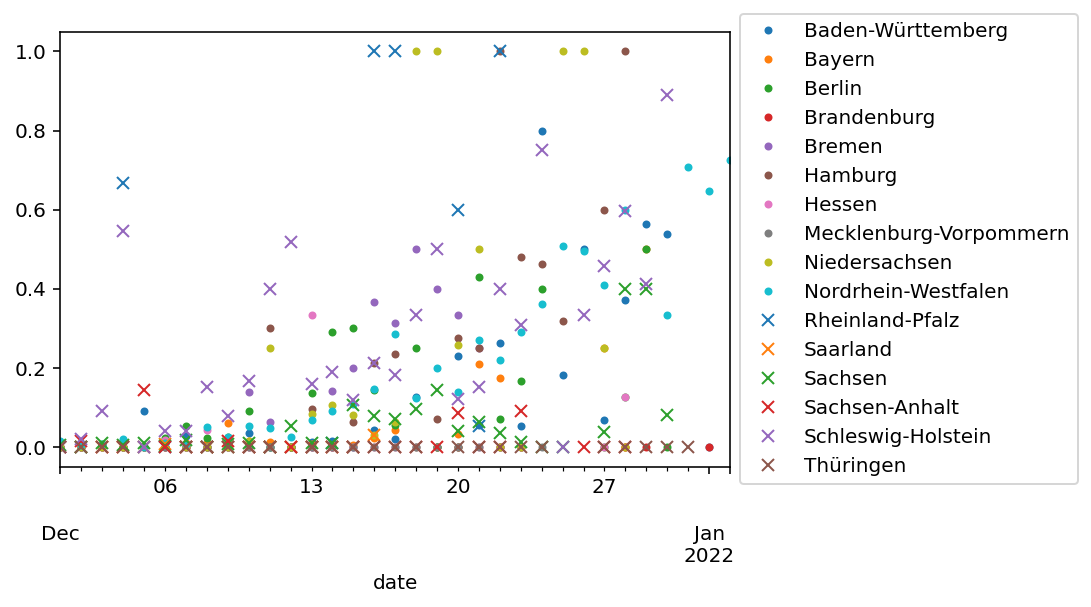

In [6]:
foo = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
foo = foo.sum(level=[0,2]).loc[:,"2021-12-01":,:]
foo['prop'] = foo.omi / foo['all']
for i,r in enumerate(foo.index.levels[0]):
    foo.loc[r]['prop'].plot(ls="", marker="." if i < 10 else "x", label=r)
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')

In [7]:
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {k: LocScaleReparam(0) for k in ["mu_a", "a"]}

@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sending_pc_to_area, sample_day, total_counts,omi_counts=None):
    mu_a_mu = numpyro.sample("mu_a_mu", dist.Normal(0, 3.0))
    mu_a_sigma = numpyro.sample("mu_a_sigma", dist.HalfNormal(2.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(2.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.2, 0.2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(.1))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_pc_to_area))

    with numpyro.plate("plate_i", n_areas):
        mu_a = numpyro.sample("mu_a", dist.Normal(mu_a_mu, mu_a_sigma))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    with numpyro.plate("plate_j", n_labs):
        a = numpyro.sample("a", dist.Normal(mu_a[sending_pc_to_area], sigma_a))
    
    logit_est = a[sending_pc] + b[sending_area] * sample_day

    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [8]:
sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc_ID, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

In [9]:
nuts_kernel = NUTS(model3)

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sending_area, sending_pc_to_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 7000/7000 [48:48<00:00,  2.39it/s, 1023 steps of size 1.17e-03. acc. prob=0.81]     


In [10]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
    a_decentered[0]     -0.91      0.43     -0.91     -1.59     -0.19    124.97      1.00
    a_decentered[1]     -0.02      0.43     -0.02     -0.70      0.69    134.29      1.00
    a_decentered[2]      0.41      0.56      0.43     -0.43      1.38    249.61      1.00
    a_decentered[3]     -1.53      0.65     -1.49     -2.60     -0.57    311.28      1.00
    a_decentered[4]     -0.77      0.50     -0.76     -1.59      0.08    154.52      1.00
    a_decentered[5]     -0.62      0.82     -0.62     -1.97      0.72    328.10      1.00
    a_decentered[6]      0.66      0.42      0.66     -0.05      1.33    143.16      1.00
    a_decentered[7]      1.05      0.62      1.07      0.06      2.07    239.90      1.00
    a_decentered[8]      1.39      0.38      1.37      0.79      2.02    118.52      1.00
    a_decentered[9]     -0.90      0.78     -0.89     -2.10      0.44    124.99      1.00
   a_dece

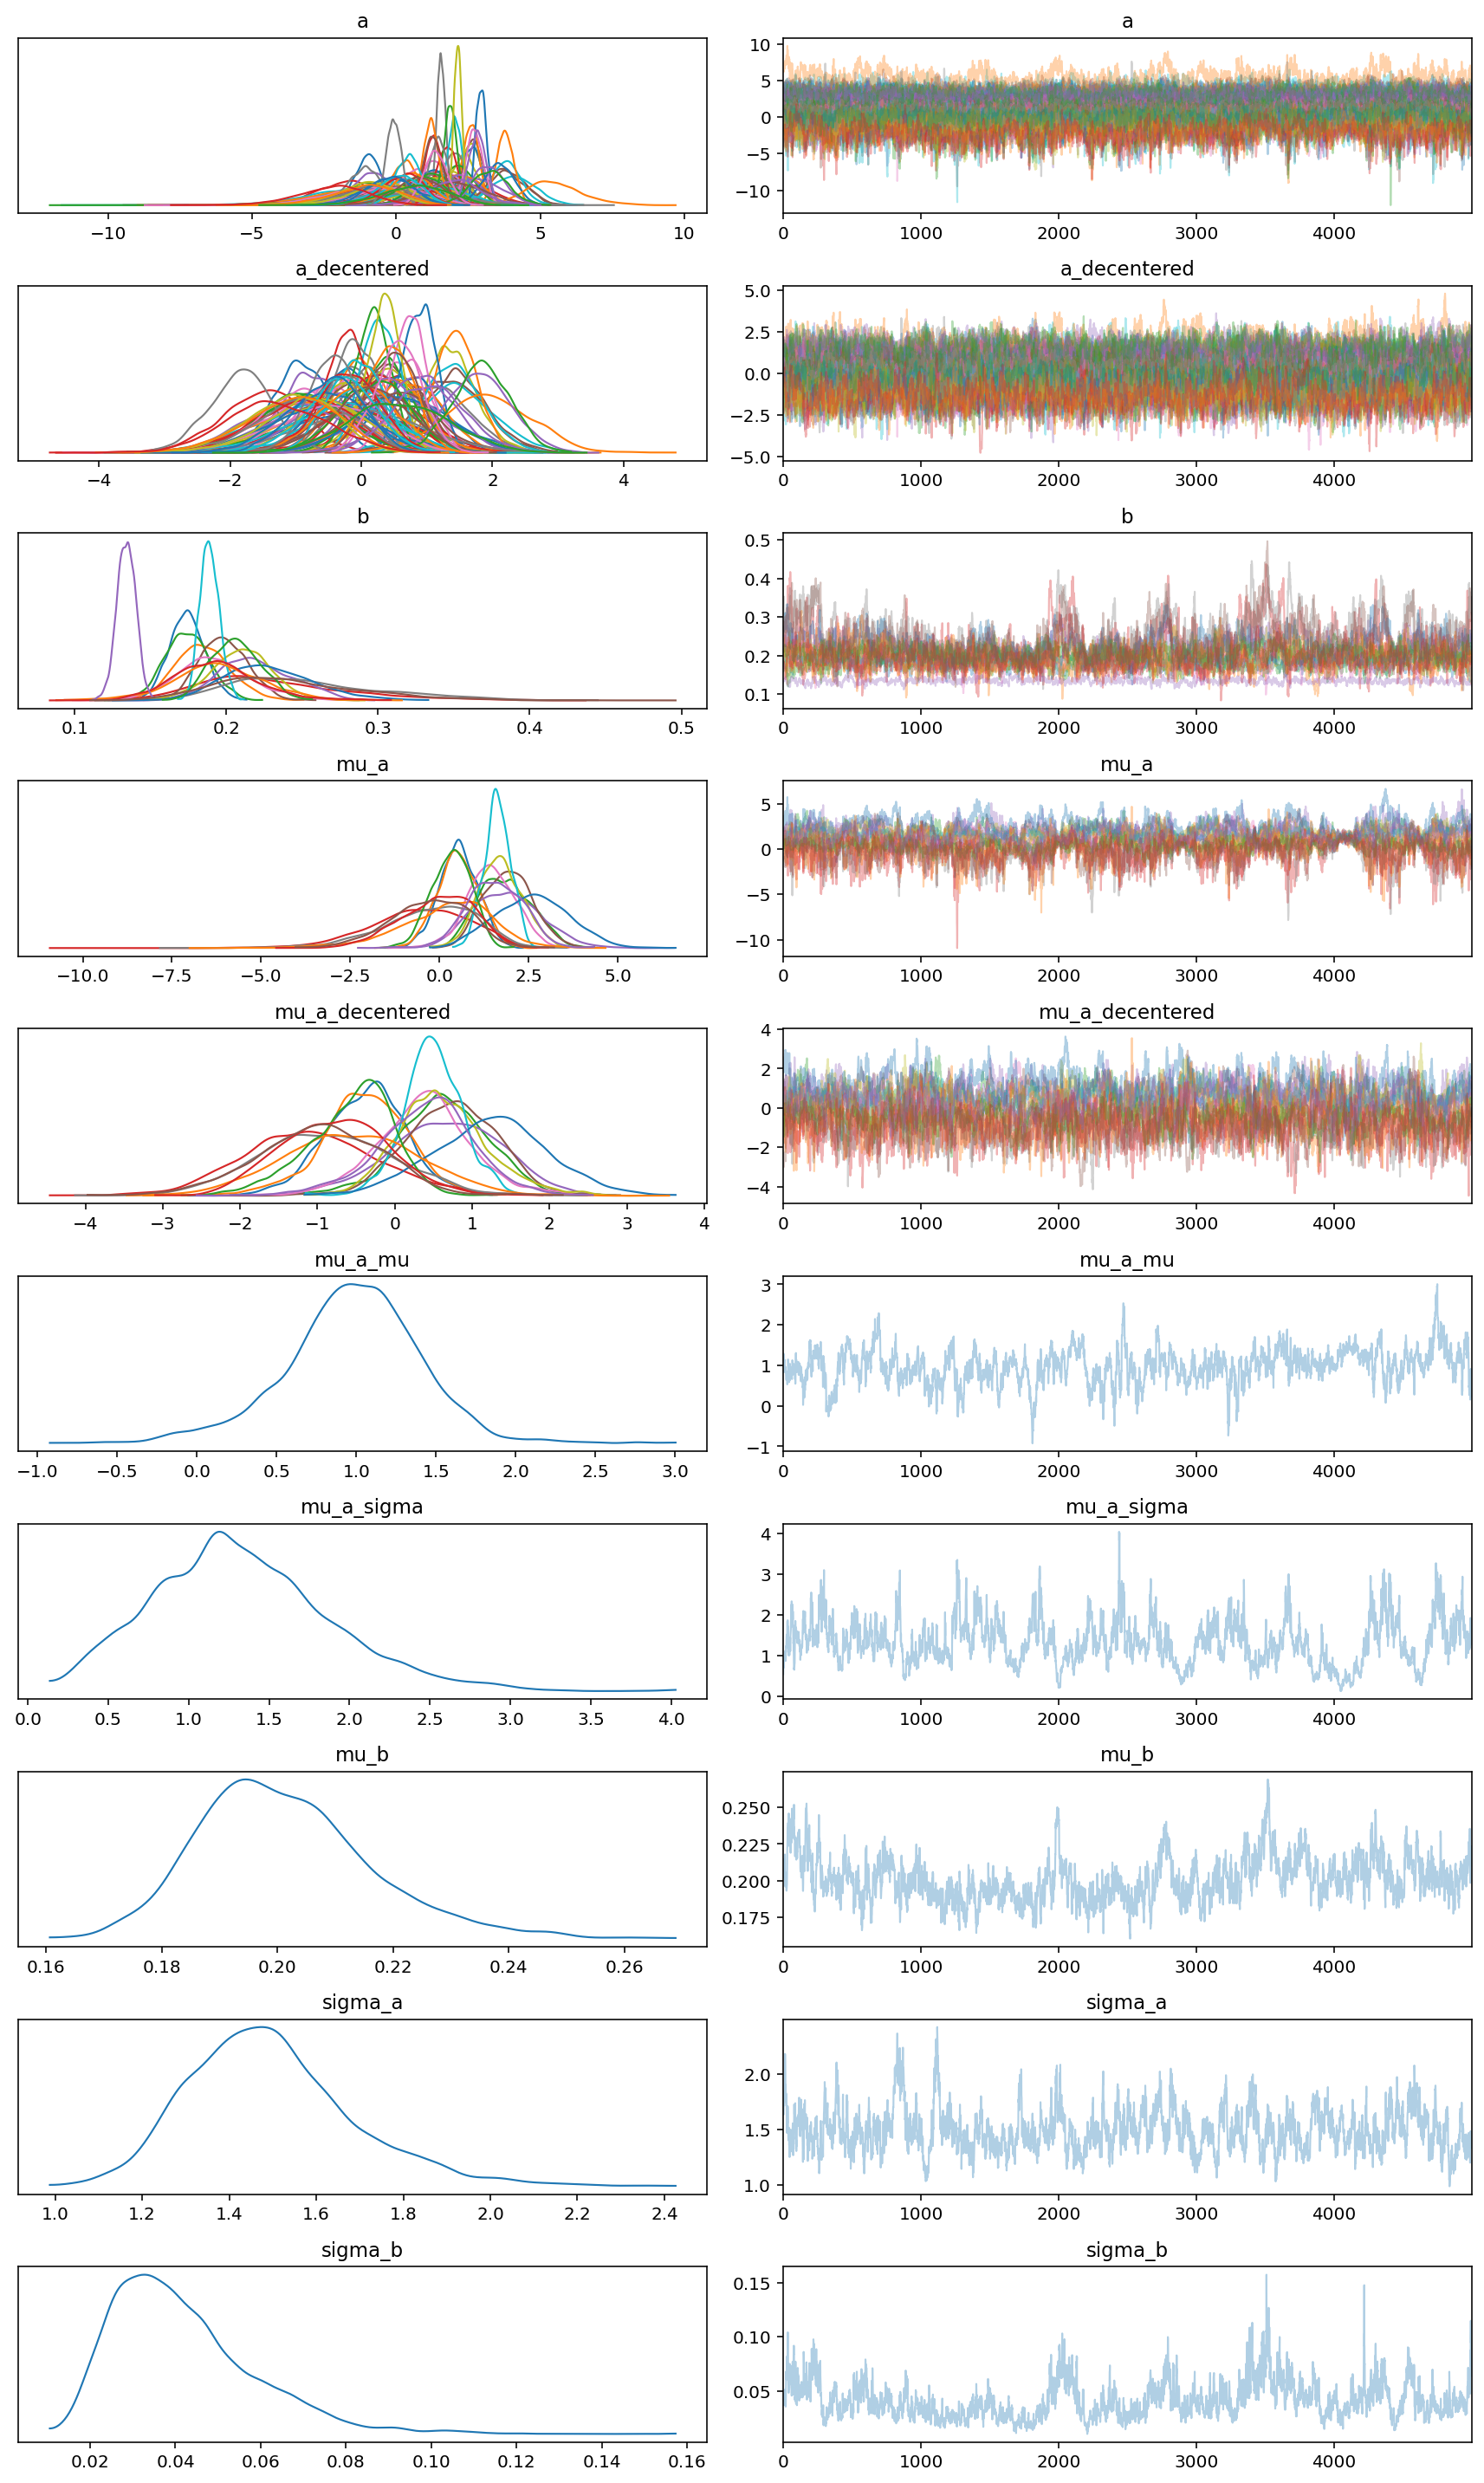

In [11]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [12]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
s = numpyro.diagnostics.summary(mcmc_samples)

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(s['mu_b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(s['mu_b']['5.0%'])-1:.1%}, {np.exp(s['mu_b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+s['mu_b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+s['mu_b']['95.0%']):.2},{np.log(2)/np.log(1+s['mu_b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    22.3% mit 90%-Konfidenzintervall [19.4%, 25.3%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    3.8 Tage mit 90%-Konfidenzintervall [3.4,4.2]
    


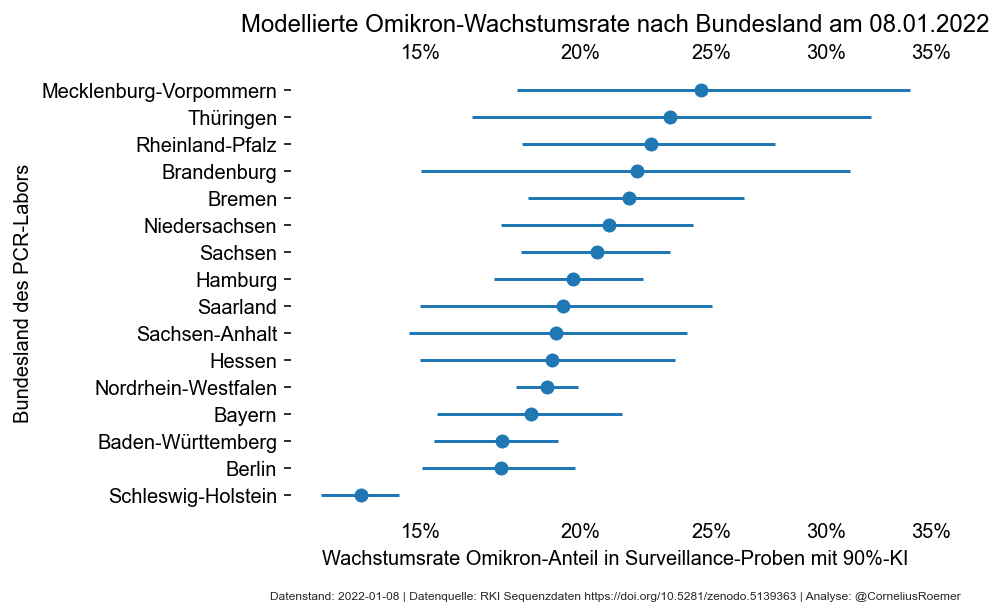

In [13]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(s['b'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([(pdf['median'])-(pdf['5.0%']),(pdf['95.0%'])-(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierte Omikron-Wachstumsrate nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Wachstumsrate Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [14]:
list(df_filtered.bundesland.values.categories)

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

In [15]:
q = [0.05,0.5,0.95]
t = (np.arange("2021-12-01","2022-01-31", dtype='datetime64[D]') - np.datetime64("today")).astype("int")
prop_bl = pd.Series(expit(np.quantile(mcmc_samples['mu_a'][0][...,np.newaxis] + mcmc_samples['b'][0][...,np.newaxis] * t[np.newaxis,np.newaxis,:], 
                                     q,
                                     axis = 0)).flatten(),
                         index = pd.MultiIndex.from_product([q, 
                                                             df_filtered.bundesland.values.categories,
                                                             np.datetime64("today") + t.astype("timedelta64[D]")],
                                                           names=['quantile',
                                                                  'bundesland',
                                                                  'date']),
                       )
prop_bl = prop_bl.reset_index().set_index(["bundesland","date","quantile"])#.pivot(columns="quantile")

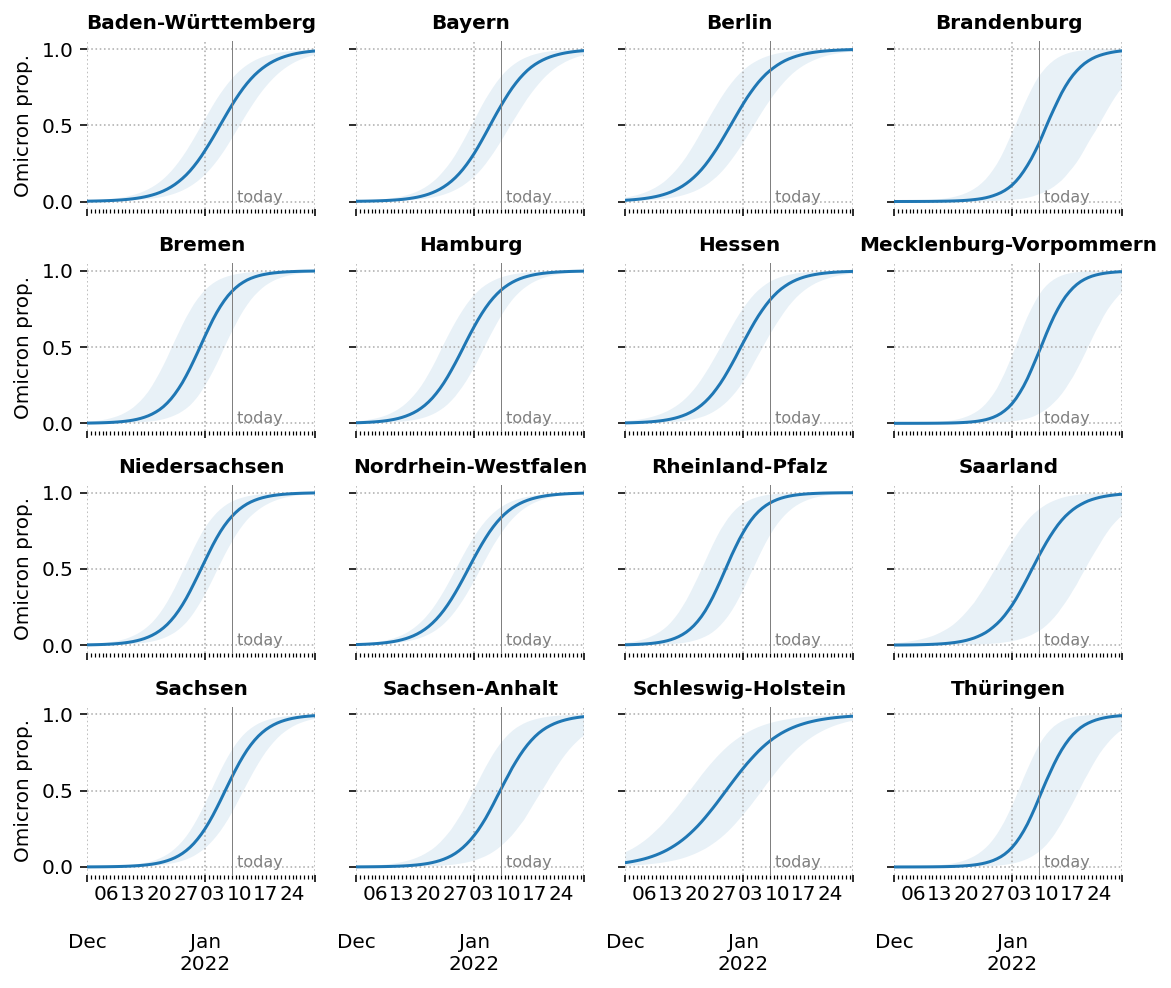

In [16]:
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    prop_bl.loc[r,:,0.5][0].plot(label=r, ax=ax[i])
    ax[i].fill_between(prop_bl.loc[r,:,0.05][0].index, prop_bl.loc[r,:,0.05][0], prop_bl.loc[r,:,0.95][0], alpha=0.1)
    ax[i].set_title(r, size=10, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Omicron prop.")
    ax[i].axvline(np.datetime64("today"), color='grey', lw=0.5)
    ax[i].text(np.datetime64("today"),0.0, " today", size=8, color='grey')
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
plt.tight_layout()

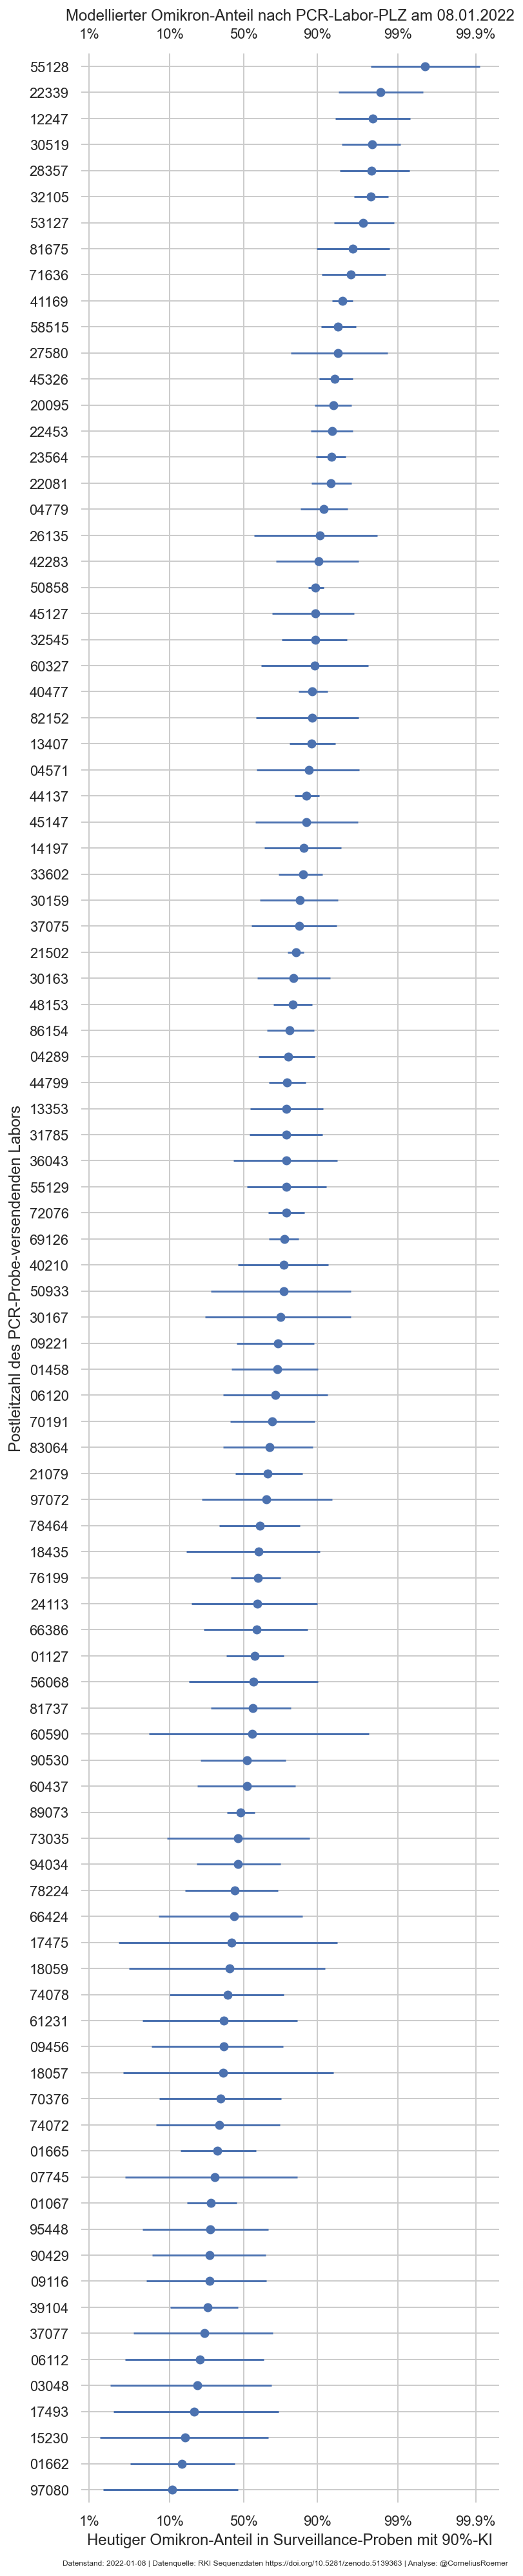

In [17]:
pdf = pd.DataFrame(s['a'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

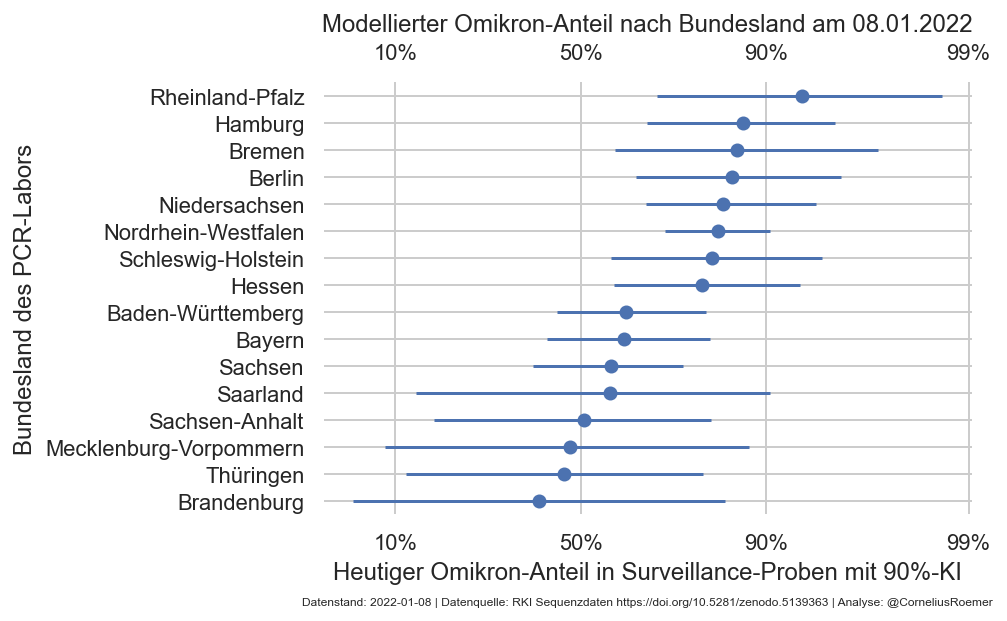

In [18]:
pdf = pd.DataFrame(s['mu_a'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [19]:
bl = plz.dissolve(by = 'bundesland')
bl.geometry = bl.simplify(1e-2, preserve_topology=False)

In [20]:
bl['land'] = "Deutschland"

In [21]:
bl

geometry  \
bundesland                                                                  
#N/A                    POLYGON ((6.83623 49.21127, 6.85915 49.22275, ...   
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...   
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...   
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...   
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...   
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...   
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...   
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...   
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...   
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...   
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...   
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...   
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...   
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...   
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...   
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...   
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...   

                        OBJECTID    plz       ags                ort  \
bundesland                                                             
#N/A                         409  57540      #N/A               #N/A   
Baden-Württemberg           1129  79588  08336014   Efringen-Kirchen   
Bayern                      3150  63791  09671114  Karlstein am Main   
Berlin                      8042  14109  11000000             Berlin   
Brandenburg                 6380  19309  12070236               Lanz   
Bremen                      2400  28777  04011000             Bremen   
Hamburg                     2308  27499  02000000            Hamburg   
Hessen                      1486  65391  06439010              Lorch   
Mecklenburg-Vorpommern      5574  19258  13076009        Bengerstorf   
Niedersachsen                253  26757  03457002             Borkum   
Nordrhein-Westfalen            1  52538  05370008            Gangelt   
Rheinland-Pfalz               24  54689  07232001             Affler   
Saarland                      92  66706  10042115               Perl   
Sachsen                     7046  08538  14523450         Weischlitz   
Sachsen-Anhalt              5540  38835  15085230         Osterwieck   
Schleswig-Holstein          1625  27498  01056025          Helgoland   
Thüringen                   4517  36419  16063011            Buttlar   

                                            landkreis  einwohner  \
bundesland                                                         
#N/A                                             #N/A        0.0   
Baden-Württemberg                   Landkreis Lörrach     8205.0   
Bayern                        Landkreis Aschaffenburg     8023.0   
Berlin                                           None    10049.0   
Brandenburg                        Landkreis Prignitz     3684.0   
Bremen                                           None    12969.0   
Hamburg                                          None        8.0   
Hessen                          Rheingau-Taunus-Kreis     3994.0   
Mecklenburg-Vorpommern  Landkreis Ludwigslust-Parchim    15989.0   
Niedersachsen                          Landkreis Leer     5207.0   
Nordrhein-Westfalen                   Kreis Heinsberg    21390.0   
Rheinland-Pfalz               Eifelkreis Bitburg-Prüm     2326.0   
Saarland                      Landkreis Merzig-Wadern     7791.0   
Sachsen                                 Vogtlandkreis     6264.0   
Sachsen-Anhalt                         Landkreis Harz    10404.0   
Schleswig-Holstein                    Kreis Pinneberg     1407.0   
Thüringe

In [22]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Text(0.5, 1.0, 'Omicron growth advantage $s = r_{Omicron} - r_{Delta}$')

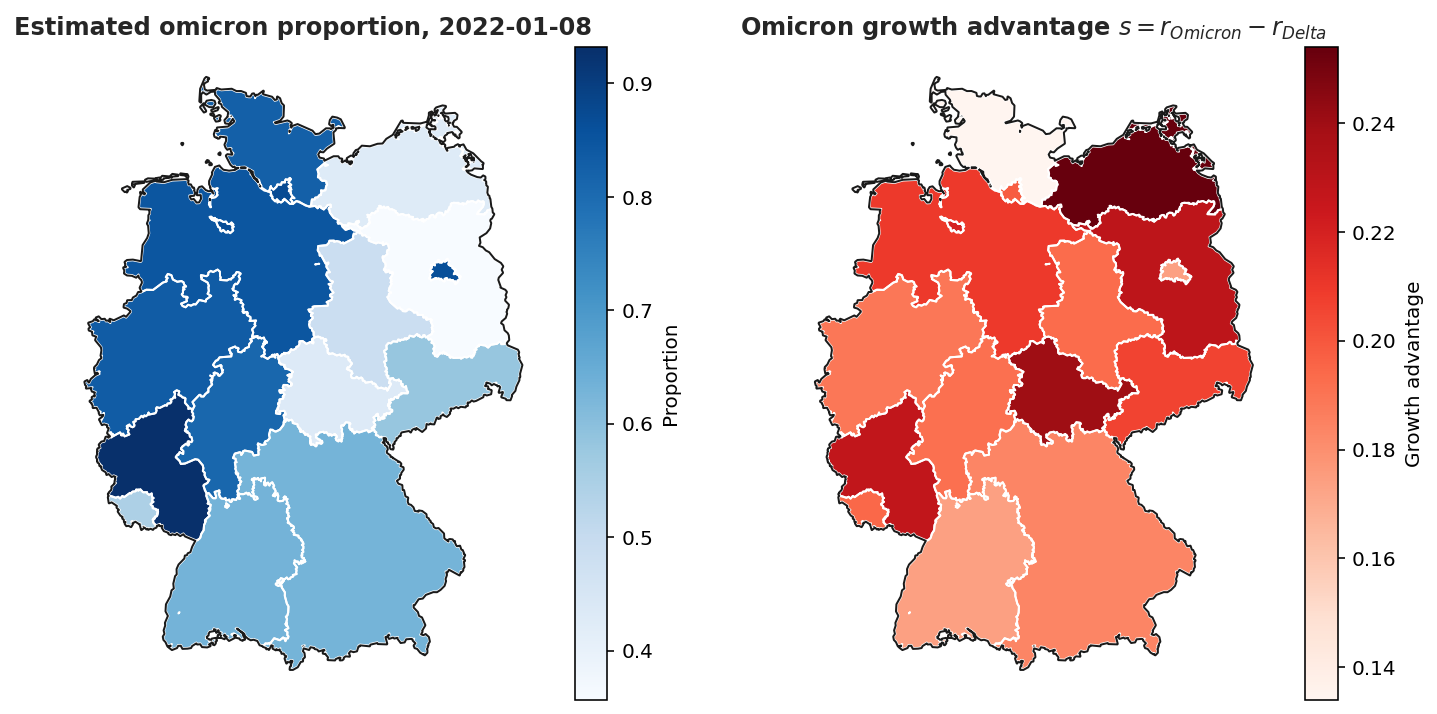

In [23]:
#sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf = pd.DataFrame({'prop':expit(s['mu_a']['mean']),
                    'prop_5%':expit(s['mu_a']['5.0%']),
                    'prop_95%':expit(s['mu_a']['95.0%']),
                    's': s['b']['mean'],
                    's_sd': s['b']['std']},
                   index=df_filtered.bundesland.values.categories)

b = bl.merge(pdf, left_index=True, right_index=True)
b.plot("prop", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Proportion"},
            figsize=(6,6),
       ax = ax[0]
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated omicron proportion, {np.datetime64('today')}", weight='bold')

b.plot("s", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Growth advantage"},
            figsize=(6,6),
       ax = ax[1]
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title("Omicron growth advantage $s = r_{Omicron} - r_{Delta}$", weight='bold')


In [24]:
bar = foo.reset_index()
bar['week'] = bar.date.dt.week
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


bundesland         week
Baden-Württemberg  48      0.005396
                   49      0.009434
                   50      0.015559
                   51      0.142077
                   52      0.145907
                             ...   
Thüringen          48      0.000000
                   49      0.000000
                   50      0.000000
                   51      0.000000
                   52      0.000000
Name: prop, Length: 80, dtype: float64

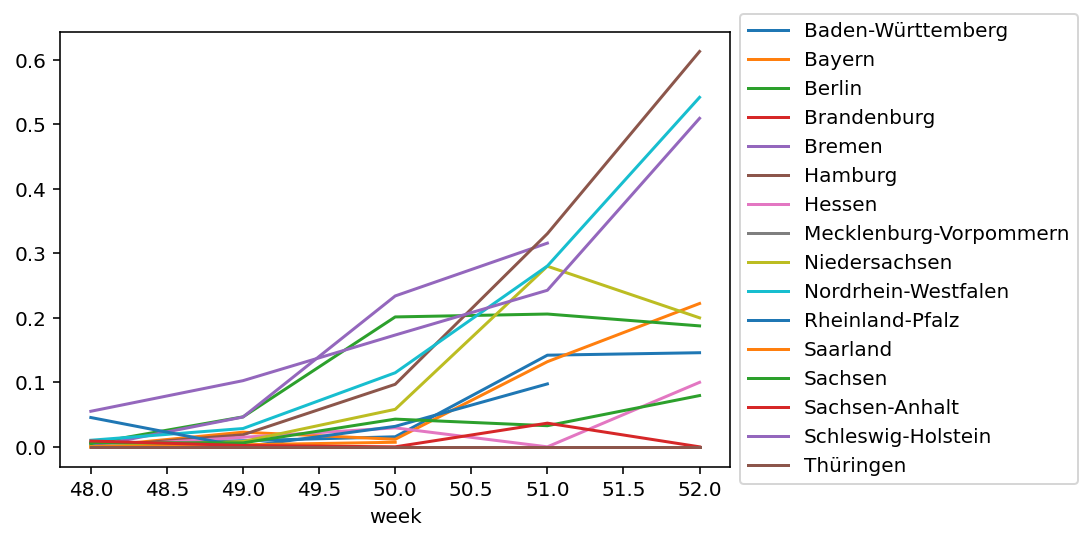

In [25]:
for r in bar.index.levels[0]:
    bar.loc[r]['prop'].plot( label=r)
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [26]:
bar.loc[:,51:52,:]

all  omi  days  sending_area  sending_pc_ID  \
bundesland             week                                                
Baden-Württemberg      51    366   52 -1344           588           6461   
                       52    281   41  -756           588           6461   
Bayern                 51    250   33 -1232           658           6741   
                       52      9    2  -693           658           6741   
Berlin                 51     34    7  -448            28            462   
                       52     16    3  -252            28            462   
Brandenburg            51     79    0  -224             7            168   
                       52      6    0  -126             7            168   
Bremen                 51     19    6  -224            28            483   
                       52      0    0  -126            28            483   
Hamburg                51    236   78  -784            98           1386   
                       52     31   19  -441            98           1386   
Hessen                 51     10    0  -448           147           1701   
                       52     10    1  -252           147           1701   
Mecklenburg-Vorpommern 51    103    0  -896            56           1218   
                       52      0    0  -504            56           1218   
Niedersachsen          51     50   14 -1008           182           2450   
                       52      5    1  -567           182           2450   
Nordrhein-Westfalen    51    799  224 -2016           511           6615   
                       52    275  149 -1134           511           6615   
Rheinland-Pfalz        51     82    8  -336           105           1302   
                       52      0    0  -189           105           1302   
Saarland               51      0    0  -224            84            973   
                       52      0    0  -126            84            973   
Sachsen                51    519   17 -1456             0            518   
                       52    151   12  -819             0            518   
Sachsen-Anhalt         51    109    4  -336            21            462   
                       52     82    0  -189            21            462   
Schleswig-Holstein     51    309   75  -448            56            819   
                       52    322  164  -252            56            819   
Thüringen              51    166    0  -336           126           1400   
                       52     15    0  -189           126           1400   

                                 prop  
bundesland             week            
Baden-Württemberg      51    0.142077  
                       52    0.145907  
Bayern                 51    0.132000  
                       52    0.222222  
Berlin                 51    0.205882  
                       52    0.187500  
Brandenburg            51    0.000000  
                       52    0.000000  
Bremen                 51    0.315789  
                       52         NaN  
Hamburg                51    0.330508  
                       52    0.612903  
Hessen                 51    0.000000  
                       52    0.100000  
Mecklenburg-Vorpommern 51    0.000000  
                       52         NaN  
Niedersachsen          51    0.280000  
                       52    0.200000  
Nordrhein-Westfalen    51    0.280350  
                       52    0.541818  
Rheinland-Pfalz        51    0.097561  
                       52         NaN  
Saarland               51         NaN  
                       52         NaN  
Sachsen                51    0.032755  
                       52    0.079470  
Sachsen-Anhalt         51    0.036697  
                       52    0.000000  
Schleswig-Holstein     51    0.242718  
                       52    0.509317  
Thüringen              51    0.000000  
                       52    0.000000

In [67]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [68]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [69]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [70]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-05         871
                  2022-01-06         640
                  2022-01-07         455
                  2022-01-08         417
                  2022-01-09         223

[11121 rows x 1 columns]

Text(0, 0.5, 'cases')

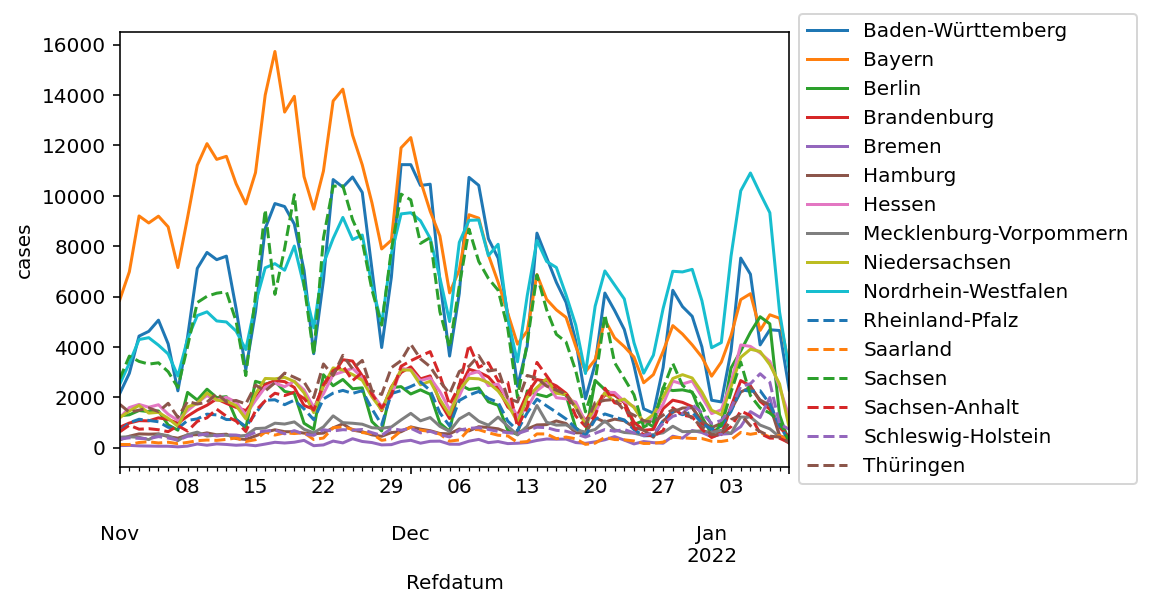

In [71]:
for i,r in enumerate(cases_land.index.levels[0]):
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=r, ls="-" if i<10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

In [72]:
bar

all  omi  days  sending_area  sending_pc_ID      prop
bundesland        week                                                       
Baden-Württemberg 48    556    3 -2160           420           4615  0.005396
                  49    954    9 -2520           588           6461  0.009434
                  50    707   11 -1932           588           6461  0.015559
                  51    366   52 -1344           588           6461  0.142077
                  52    281   41  -756           588           6461  0.145907
...                     ...  ...   ...           ...            ...       ...
Thüringen         48     24    0  -540            90           1000  0.000000
                  49    143    0  -630           126           1400  0.000000
                  50    240    0  -483           126           1400  0.000000
                  51    166    0  -336           126           1400  0.000000
                  52     15    0  -189           126           1400  0.000000

[80 rows x 6 columns]

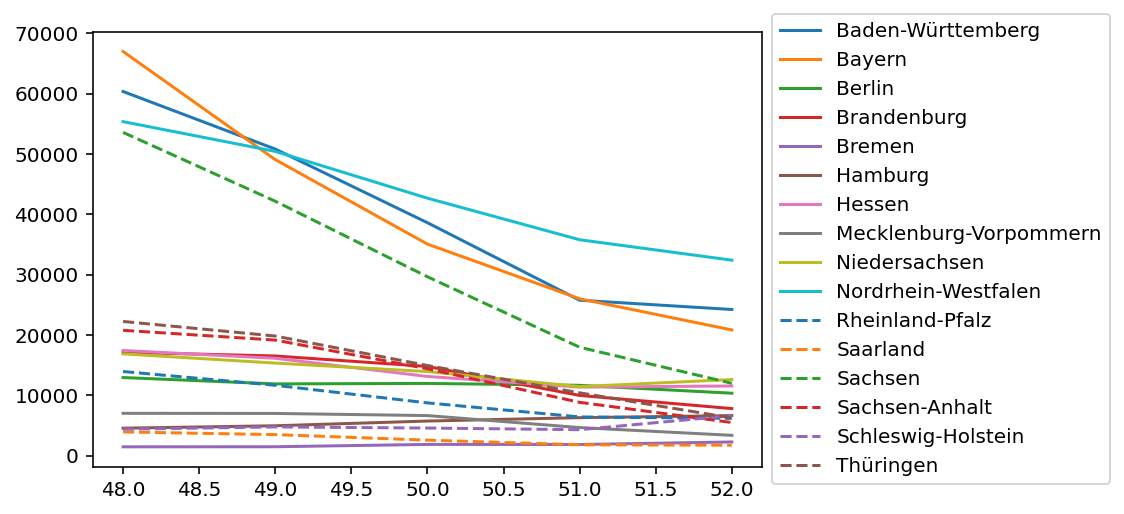

In [73]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum.dt.isocalendar().week
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Omicron cases')

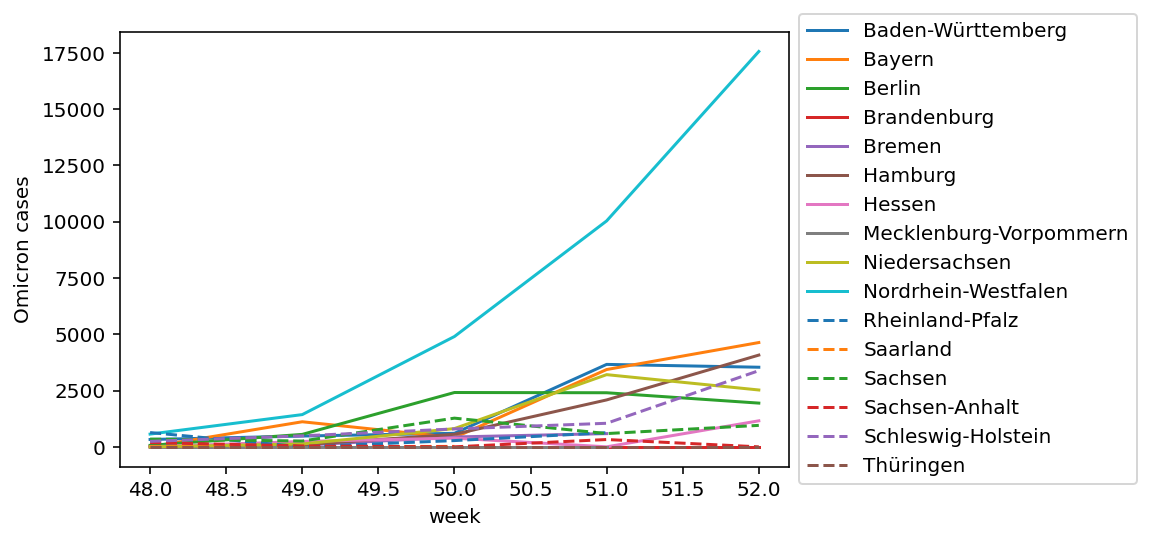

In [74]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum.dt.isocalendar().week
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

In [75]:
bar

all  omi  days  sending_area  sending_pc_ID      prop
bundesland        week                                                       
Baden-Württemberg 48    556    3 -2160           420           4615  0.005396
                  49    954    9 -2520           588           6461  0.009434
                  50    707   11 -1932           588           6461  0.015559
                  51    366   52 -1344           588           6461  0.142077
                  52    281   41  -756           588           6461  0.145907
...                     ...  ...   ...           ...            ...       ...
Thüringen         48     24    0  -540            90           1000  0.000000
                  49    143    0  -630           126           1400  0.000000
                  50    240    0  -483           126           1400  0.000000
                  51    166    0  -336           126           1400  0.000000
                  52     15    0  -189           126           1400  0.000000

[80 rows x 6 columns]

In [76]:
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-05         871
                  2022-01-06         640
                  2022-01-07         455
                  2022-01-08         417
                  2022-01-09         223

[11121 rows x 1 columns]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


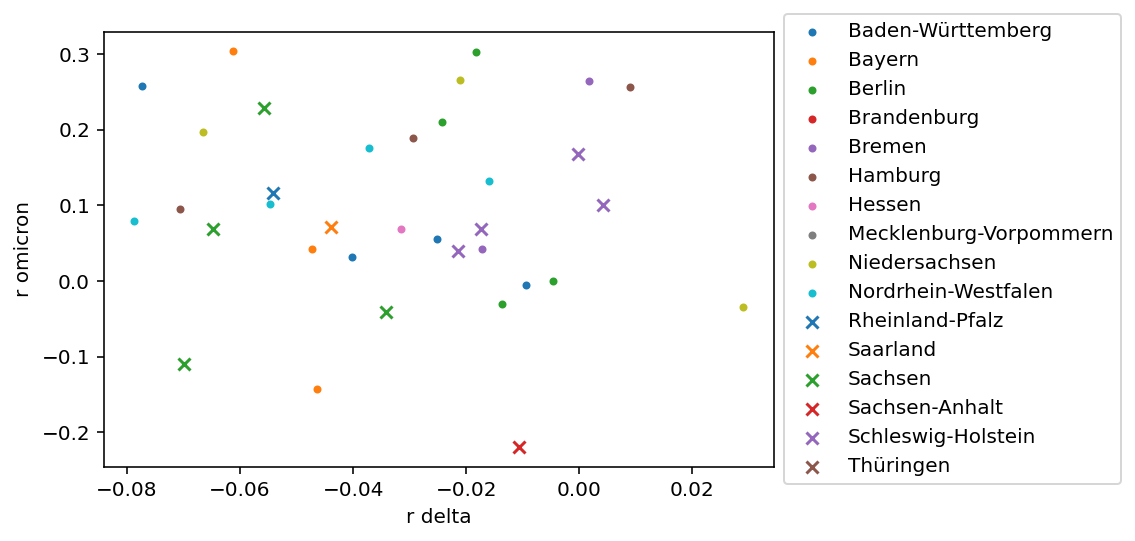

In [77]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum.dt.isocalendar().week
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=r, marker = "." if i <10 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [78]:
c = cases_land.loc[:,"2021-12-08":"2021-12-21",:] / cases_land.loc[:,"2021-12-01":"2021-12-14",:].values
foo = np.log(c).mean(level=0).rename(columns={'AnzahlFall':'r'}) / 7
foo['r_sd'] = np.log(c).std(level=0).values / 7

In [79]:
foo = foo.merge(pdf, left_index=True, right_index=True)

<AxesSubplot:xlabel='r', ylabel='s'>

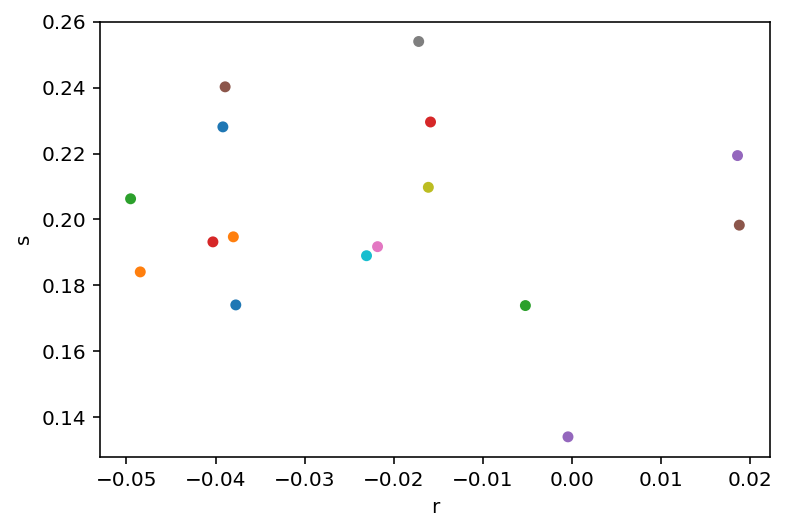

In [80]:
foo.plot.scatter("r","s", c = [f'C{i}' for i in range(foo.shape[0])])
#plt.legend()

Text(0, 0.5, 'Growth rate Omicron')

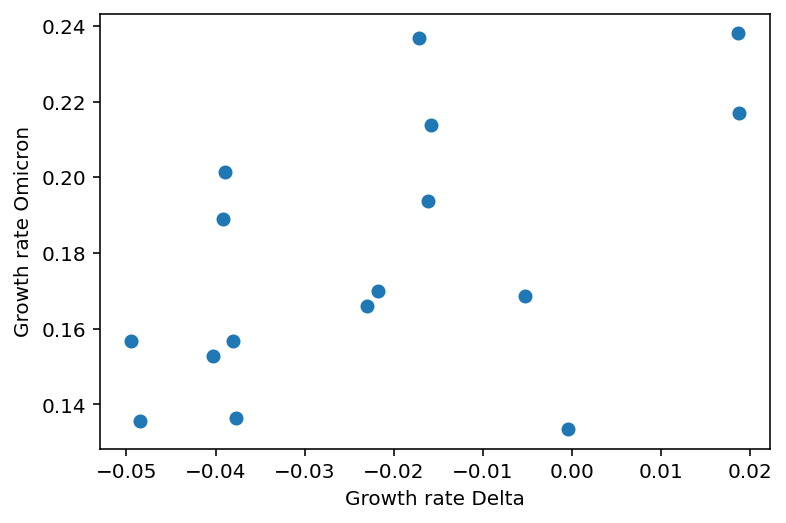

In [81]:
plt.scatter(foo['r'], foo['s'] + foo['r'])
plt.xlabel("Growth rate Delta")
plt.ylabel("Growth rate Omicron")

In [82]:
foo.to_csv(f"Germany_SGTF_{np.datetime64('today')}.csv")

In [83]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

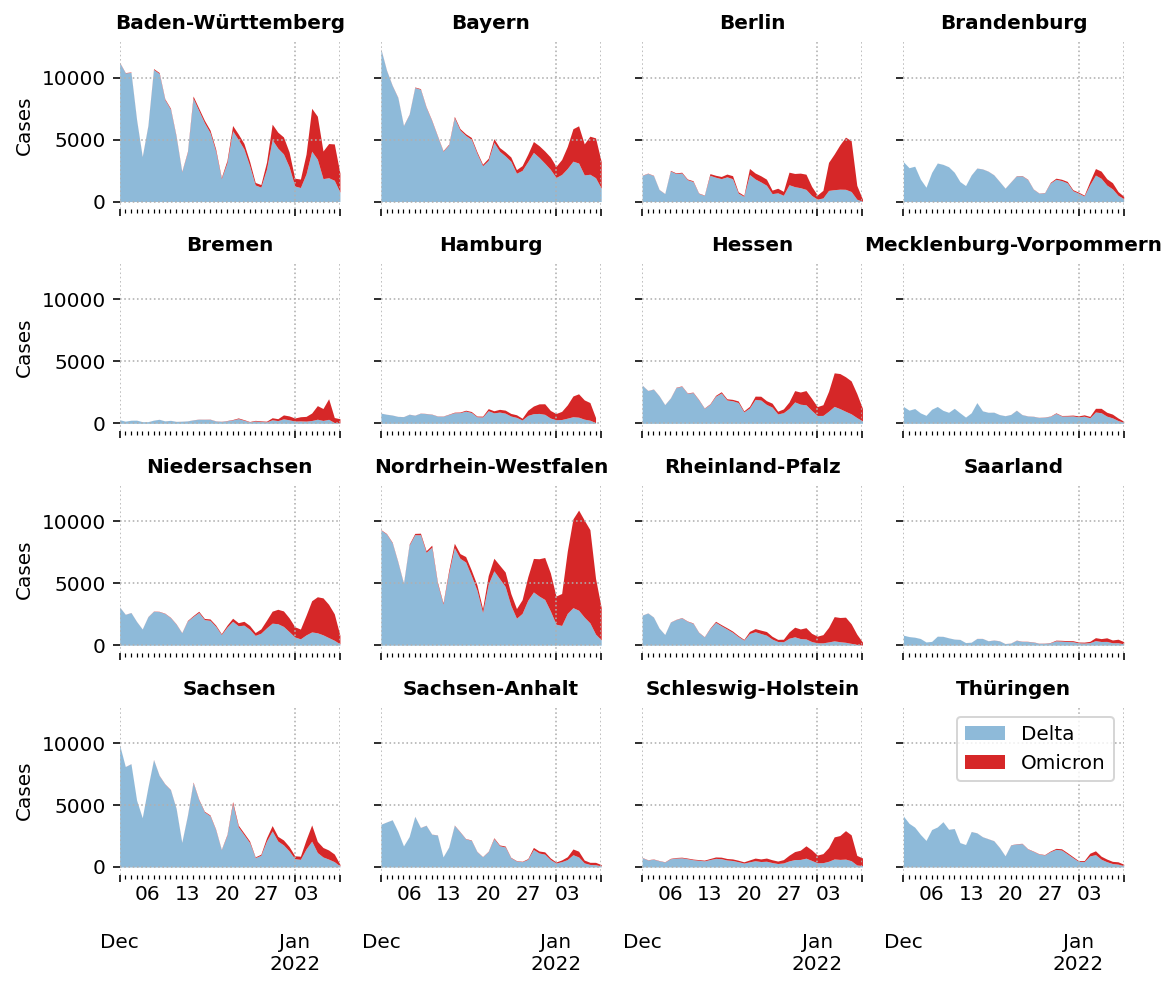

In [176]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] 
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()

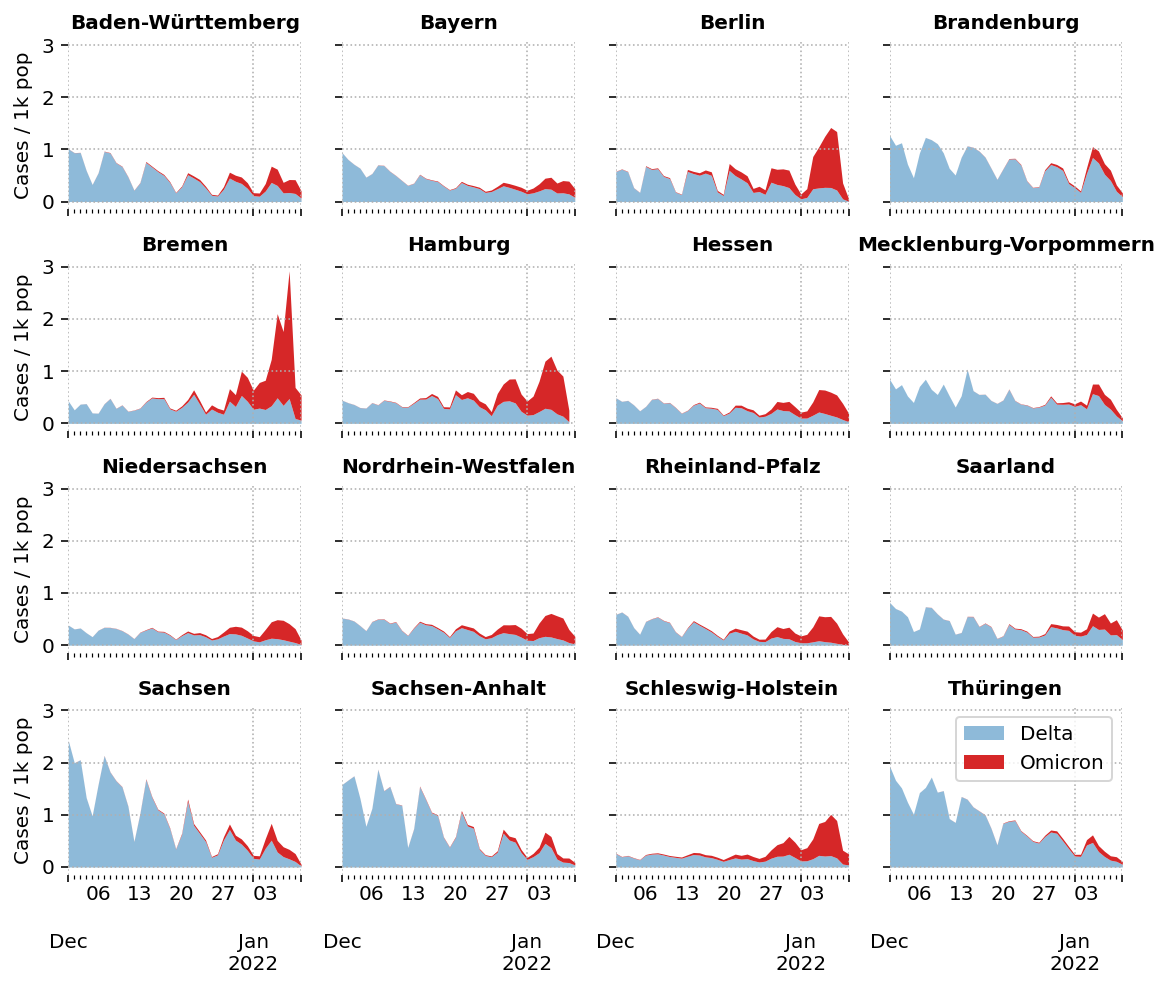

In [174]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()